# Coding Controllers as Python Generators

## Python Generators and the Yield Statement

What we seek is are techniques to encapsulate control algorithms that have state. There are several ways this can be done in Python (roughly in order of increasing capability and complexity):

* Co-routines written using the Python `yield` statement
* Classes
* Threads

Classes, in particular, provide a means to encapsulate data and functionality within a single software entity. Classes are widely used in Python programming, and should eventually be part of every Python programmer's toolkit.

However, as we demonstrate below, in many cases a more compact and readable version of a control algorithm can be coded using just the Python `yield` statement.  

`yield` allows repetitive use of a function to produce a sequence of values. A function incorporating a `yield` statement is called a `generator`.  Here's an example of a generator that produces a sequence of three numbers.

In [40]:
def my_numbers():
    yield 0
    yield 1
    yield 2.7182818
    yield 3.1415926

How we do use this generator?  One way is to use it as an iterator.

In [41]:
for n in my_numbers():
    print(n)

0
1
2.7182818
3.1415926


Each reference to the generator causes execution to move forward to the next `yield` statement, returns the given value to the calling function, then returns control to the calling function. 

But that's not the only way to use a generator. Another way is to create an instance of the generator, then use `send(None)` to execute each successive `yield` statement.

In [42]:
numbers = my_numbers()

print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))
print(numbers.send(None))

0
1
2.7182818
3.1415926


The `send()` method provides two-way communication with the generator. Here's an example.

In [43]:
def your_numbers():
    a = yield 
    b = yield a**2
    c = yield b**2
    yield c**2

In [44]:
numbers = your_numbers()
print(numbers.send(None))
print(numbers.send(4))
print(numbers.send(12))
print(numbers.send(42))

None
16
144
1764


Notice that there is no way to `send()` a value to the generator for use in the first `yield` statement. The implication is that an initial `send(None)` is required to initialize the generator. After that, each successive `send()` provides a value that can be assigned to the left-hand side of the `yield` statement.  Execution moves forward until the next `yield` statement.

Here's another implementation. In this case we place `yield` statement within an infinite loop.

In [45]:
def our_numbers():
    n = 0
    while True:
        n = yield n*n
        
numbers = our_numbers()   # create the generator
numbers.send(None)        # initialize

print(numbers.send(4))
print(numbers.send(12))
print(numbers.send(42))

16
144
1764


## Example: Relay Control with Hysteresis

Relay control can work well but is sensitive to measurement noise. Even a relatively small amount of measurement noise causes the manipulated variable to rapidly cycle between extreme values. Needless to say, this would be a unacceptable in large scale chemical plants.

A common workaround is add a small amount of hystersis to the controller. Here's an example from the Inkbird IB-16 controller that is typical of a commercial devices found in the food and pharaceutical industries.

<img src='images/Inkbird-16.png' style="float: left;padding-right:10px;"></img>
<img src='images/Inkbird-16-Manual.png' style="float: right;padding-left:30px;"></img>

The controller is modeled

$$MV_{k+1} = \begin{cases} 100 & \mbox{if }PV_k \leq SP - d \\ 0 & \mbox{if }PV_k \geq SP + d \\ MV_k\end{cases}$$

This can be coded as follows

In [50]:
def relay(d, SP):
    """Relay control with hysteresis."""
    MV = 0
    while True:
        PV = yield MV
        if PV < SP - d:
            MV = 100
        elif PV > SP + d:
            MV = 0

### Simulation

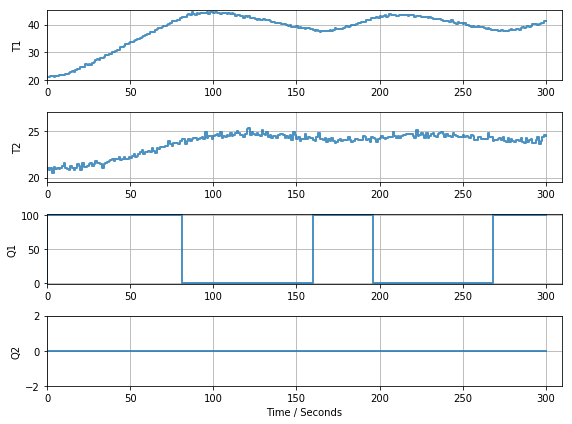

Surrogate TCLab disconnected successfully.


In [51]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

thermostat = relay(2,40)    # create thermostat
thermostat.send(None)       # initialize thermostat

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(300):
        PV = a.T1                         # get measurements
        MV = thermostat.send(PV)          # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

### Experiment

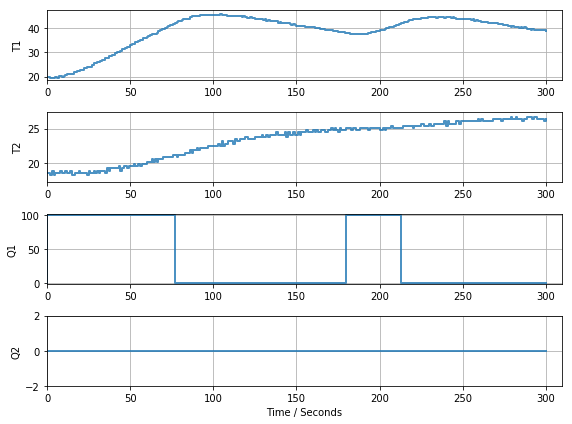

TCLab disconnected successfully.


In [53]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=True, speedup=1)

thermostat = relay(2,40)    # create thermostat
thermostat.send(None)       # initialize thermostat

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(300, strict=False):
        PV = a.T1                         # get measurements
        MV = thermostat.send(PV)          # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

## Example: Proportional-Integral Control

In [6]:
def PI(Kp, Ki, tstep):
    """Proportional Integral Control."""
    e = 0
    MV = 0
    while True:
        PV, SP = yield MV
        e_last = e
        MV_last = MV
        e = SP - PV
        MV = MV_last + Kp*(e - e_last) + Ki*tstep*e
        MV = max(0, min(100, MV))

## Simulation

In [7]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=False, speedup=10)

tstep = 1
SP = 40

thermostat = PI(3, 0.03, tstep)    # create thermostat
thermostat.send(None)       # initialize thermostat

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(600, tstep):
        PV = a.T1                         # get measurements
        MV = thermostat.send([PV,SP])          # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display

Surrogate TCLab disconnected successfully.


KeyboardInterrupt: 

## Experiment

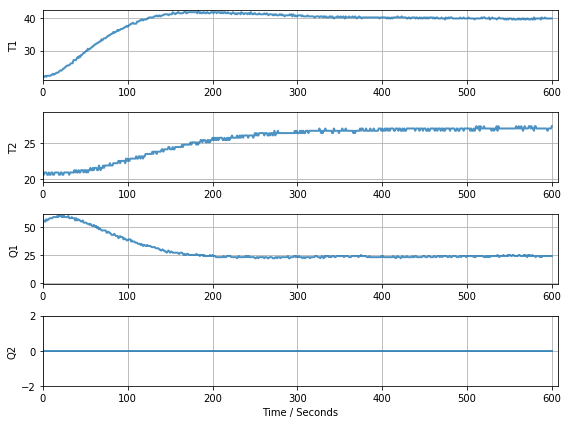

TCLab disconnected successfully.


In [8]:
from tclab import clock, setup, Historian, Plotter
TCLab = setup(connected=True, speedup=1)

tstep = 1
SP = 40

thermostat = PI(3, 0.03, tstep)    # create thermostat
thermostat.send(None)       # initialize thermostat

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(600, tstep):
        PV = a.T1                         # get measurements
        MV = thermostat.send([PV,SP])          # compute control action
        a.U1 = MV                         # apply command
        p.update(t)                       # update information display